In [82]:
import numpy as np 
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
from head import AmplitudePhaseDistance
from geomstats.geometry.functions import SRVF
from matplotlib import cm
import matplotlib
from matplotlib.colors import Normalize
plt.rcParams.update({
                     "axes.spines.right" : False,
                     "axes.spines.top" : False,
                     "font.size": 15,
                     "savefig.dpi": 400,
                     "savefig.bbox": 'tight',
                     'text.latex.preamble': r'\usepackage{amsfonts}'
                    }
                   )

In [2]:
def load_spectra(path):
    for itr in range(7):
        spectra_iteration = pd.read_excel(path + str(itr) + '.xlsx').values
        wavelength = spectra_iteration[:,0]
        if itr == 0:
            spectra_all = spectra_iteration[:,1:]
        else:
            spectra_all = np.hstack((spectra_all, spectra_iteration[:,1:]))
    return spectra_all, wavelength 

def load_x(path):
    all_x = np.load(path + str(7) + '/train_x.npy') #All x_values from 0th iteration to iteration-1 
    return all_x

In [3]:
AP_ROD_y, wavelength = load_spectra('../data_AP_ROD/')
AP_SPHERE_y, _ = load_spectra('../data_AP_SPHERE/')
SRVF_ROD_y, _ = load_spectra('../data_SRVF_ROD/')
SRVF_SPHERE_y, _ = load_spectra('../data_SRVF_SPHERE/')
euclidean_ROD_y, _ = load_spectra('../data_euclidean_ROD/')
euclidean_SPHERE_y, _ = load_spectra('../data_euclidean_SPHERE/')
peakwv_ROD_y, _ = load_spectra('../data_peakwv_ROD/')
peakwv_SPHERE_y, _ = load_spectra('../data_peakwv_SPHERE/')

In [4]:
AP_ROD_x = load_x('../data_AP_ROD/')
AP_SPHERE_x = load_x('../data_AP_SPHERE/')
SRVF_ROD_x = load_x('../data_SRVF_ROD/')
SRVF_SPHERE_x = load_x('../data_SRVF_SPHERE/')
euclidean_ROD_x = load_x('../data_euclidean_ROD/')
euclidean_SPHERE_x = load_x('../data_euclidean_SPHERE/')
peakwv_ROD_x = load_x('../data_peakwv_ROD/')
peakwv_SPHERE_x = load_x('../data_peakwv_SPHERE/')

### All the data from the sphere and rod optimizations in one array

In [5]:
target = pd.read_excel('Target_Rod.xlsx')
target = np.asarray(target)
xt = target[:,0]
rod_target = target[:,1]
target = pd.read_excel('Target_Sphere.xlsx')
target = np.asarray(target)
xt = target[:,0]
sphere_target = target[:,1]

In [6]:
#spectra
SPHERES_y = np.hstack((peakwv_SPHERE_y, euclidean_SPHERE_y, SRVF_SPHERE_y, AP_SPHERE_y)).T
RODS_y = np.hstack((peakwv_ROD_y, euclidean_ROD_y, SRVF_ROD_y, AP_ROD_y)).T

In [7]:
#concentrations
SPHERES_x = np.vstack((peakwv_SPHERE_x, euclidean_SPHERE_x, SRVF_SPHERE_x, AP_SPHERE_x)).T
RODS_x = np.vstack((peakwv_ROD_x, euclidean_ROD_x, SRVF_ROD_x, AP_ROD_x)).T

In [8]:
def Euclidean(f1,f2):
    d = distance.euclidean(f1,f2)    
    return -d

def peakwv_sphere(f1,f2):
    d = (np.abs((np.argmax(f1) - np.argmax(f2))/100) + np.abs(np.max(f1) - np.max(f2)))
    return -d

def AP(f1,f2):
    da, dp = AmplitudePhaseDistance(f1,f2,xt)
    return -(da + dp)

def SRVF_metric(f1,f2):
    target = pd.read_excel('Target_Rod.xlsx')
    target = np.asarray(target)
    xt = target[:,0]
    M = SRVF(xt.reshape(-1,1).flatten())
    yi = np.asarray(f1).reshape(-1,1).flatten()
    yt = np.asarray(f2).reshape(-1,1).flatten()
    score = -M.metric.dist(yt,yi)
    return score
    

In [54]:
def calculate_distance(metric, concentrations, spectra, target):
    dist = []
    spectra = spectra.T
    for i in range(spectra.shape[0]):
        d = metric(target, spectra[i,:])
        dist.append(d)
    dist = np.array(dist).reshape(-1,1)
    array = np.hstack((dist, concentrations, spectra))
    sorted_array = array[np.argsort(array[:, 0])]
    return sorted_array 

The spectra of each optimization will be compared with one similarity metric

In [105]:
metric_name = peakwv_sphere
peakwv_SPHERE = calculate_distance(metric_name, peakwv_SPHERE_x, peakwv_SPHERE_y, sphere_target)
peakwv_ROD = calculate_distance(metric_name, peakwv_ROD_x, peakwv_ROD_y, rod_target)
euclidean_ROD = calculate_distance(metric_name, euclidean_ROD_x, euclidean_ROD_y, rod_target)
euclidean_SPHERE = calculate_distance(metric_name, euclidean_SPHERE_x, euclidean_SPHERE_y, sphere_target)
SRVF_ROD = calculate_distance(metric_name, SRVF_ROD_x, SRVF_ROD_y, rod_target)
SRVF_SPHERE = calculate_distance(metric_name, SRVF_SPHERE_x, SRVF_SPHERE_y, sphere_target)
AP_ROD = calculate_distance(metric_name, AP_ROD_x, AP_ROD_y, rod_target)
AP_SPHERE = calculate_distance(metric_name, AP_SPHERE_x, AP_SPHERE_y, sphere_target)

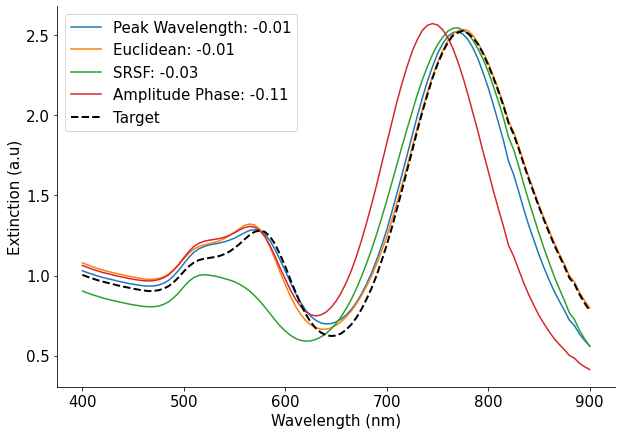

In [106]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(wavelength, peakwv_ROD[-1,3:], label = 'Peak Wavelength: ' + str(round(peakwv_ROD[-1,0], 2)))
plt.plot(wavelength, euclidean_ROD[-1,3:], label = 'Euclidean: ' + str(round(euclidean_ROD[-1,0], 2)))
plt.plot(wavelength, SRVF_ROD[-1,3:], label = 'SRSF: ' + str(round(SRVF_ROD[-1,0],2)))
plt.plot(wavelength, AP_ROD[-1,3:], label = 'Amplitude Phase: ' + str(round(AP_ROD[-1,0], 2)))
plt.plot(wavelength, rod_target,linewidth = 2.0, ls='--', color = 'k', label = 'Target')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Extinction (a.u)')
plt.savefig('../figures/same_metric_distance/Peakwv_RODS.png')

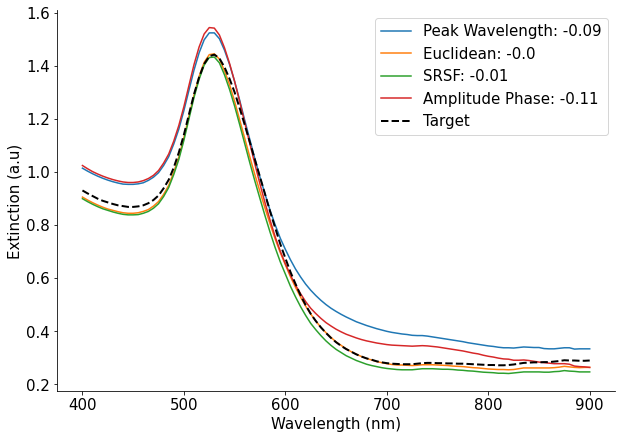

In [107]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(wavelength, peakwv_SPHERE[-1,3:], label = 'Peak Wavelength: ' + str(round(peakwv_SPHERE[-1,0], 2)))
plt.plot(wavelength, euclidean_SPHERE[-1,3:], label = 'Euclidean: ' + str(round(euclidean_SPHERE[-1,0], 2)))
plt.plot(wavelength, SRVF_SPHERE[-1,3:], label = 'SRSF: ' + str(round(SRVF_SPHERE[-1,0],2)))
plt.plot(wavelength, AP_SPHERE[-1,3:], label = 'Amplitude Phase: ' + str(round(AP_SPHERE[-1,0], 2)))
plt.plot(wavelength, sphere_target,linewidth = 2.0, ls='--', color = 'k', label = 'Target')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Extinction (a.u)')
plt.savefig('../figures/same_metric_distance/Peakwv_SPHERES.png')

In [108]:
metric_name = Euclidean
peakwv_SPHERE = calculate_distance(metric_name, peakwv_SPHERE_x, peakwv_SPHERE_y, sphere_target)
peakwv_ROD = calculate_distance(metric_name, peakwv_ROD_x, peakwv_ROD_y, rod_target)
euclidean_ROD = calculate_distance(metric_name, euclidean_ROD_x, euclidean_ROD_y, rod_target)
euclidean_SPHERE = calculate_distance(metric_name, euclidean_SPHERE_x, euclidean_SPHERE_y, sphere_target)
SRVF_ROD = calculate_distance(metric_name, SRVF_ROD_x, SRVF_ROD_y, rod_target)
SRVF_SPHERE = calculate_distance(metric_name, SRVF_SPHERE_x, SRVF_SPHERE_y, sphere_target)
AP_ROD = calculate_distance(metric_name, AP_ROD_x, AP_ROD_y, rod_target)
AP_SPHERE = calculate_distance(metric_name, AP_SPHERE_x, AP_SPHERE_y, sphere_target)

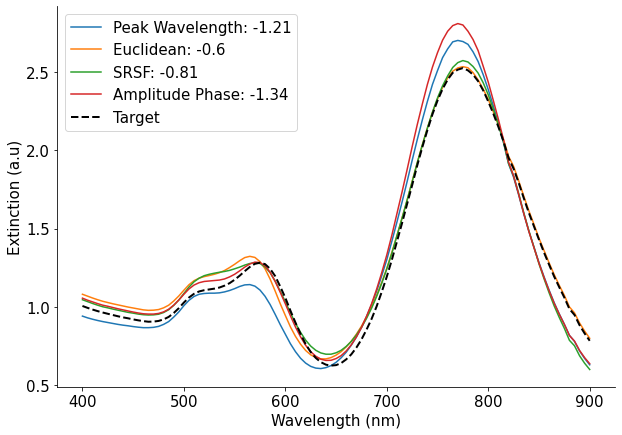

In [109]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(wavelength, peakwv_ROD[-1,3:], label = 'Peak Wavelength: ' + str(round(peakwv_ROD[-1,0], 2)))
plt.plot(wavelength, euclidean_ROD[-1,3:], label = 'Euclidean: ' + str(round(euclidean_ROD[-1,0], 2)))
plt.plot(wavelength, SRVF_ROD[-1,3:], label = 'SRSF: ' + str(round(SRVF_ROD[-1,0],2)))
plt.plot(wavelength, AP_ROD[-1,3:], label = 'Amplitude Phase: ' + str(round(AP_ROD[-1,0], 2)))
plt.plot(wavelength, rod_target,linewidth = 2.0, ls='--', color = 'k', label = 'Target')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Extinction (a.u)')
plt.savefig('../figures/same_metric_distance/Euclidean_RODS.png')

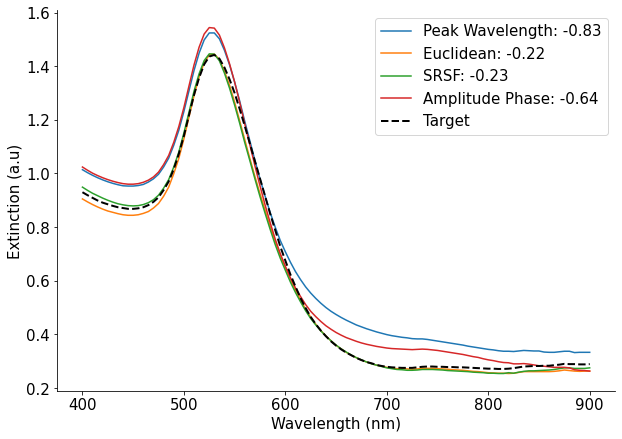

In [110]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(wavelength, peakwv_SPHERE[-1,3:], label = 'Peak Wavelength: ' + str(round(peakwv_SPHERE[-1,0], 2)))
plt.plot(wavelength, euclidean_SPHERE[-1,3:], label = 'Euclidean: ' + str(round(euclidean_SPHERE[-1,0], 2)))
plt.plot(wavelength, SRVF_SPHERE[-1,3:], label = 'SRSF: ' + str(round(SRVF_SPHERE[-1,0],2)))
plt.plot(wavelength, AP_SPHERE[-1,3:], label = 'Amplitude Phase: ' + str(round(AP_SPHERE[-1,0], 2)))
plt.plot(wavelength, sphere_target,linewidth = 2.0, ls='--', color = 'k', label = 'Target')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Extinction (a.u)')
plt.savefig('../figures/same_metric_distance/Euclidean_SPHERES.png')

In [111]:
metric_name = SRVF_metric
peakwv_SPHERE = calculate_distance(metric_name, peakwv_SPHERE_x, peakwv_SPHERE_y, sphere_target)
peakwv_ROD = calculate_distance(metric_name, peakwv_ROD_x, peakwv_ROD_y, rod_target)
euclidean_ROD = calculate_distance(metric_name, euclidean_ROD_x, euclidean_ROD_y, rod_target)
euclidean_SPHERE = calculate_distance(metric_name, euclidean_SPHERE_x, euclidean_SPHERE_y, sphere_target)
SRVF_ROD = calculate_distance(metric_name, SRVF_ROD_x, SRVF_ROD_y, rod_target)
SRVF_SPHERE = calculate_distance(metric_name, SRVF_SPHERE_x, SRVF_SPHERE_y, sphere_target)
AP_ROD = calculate_distance(metric_name, AP_ROD_x, AP_ROD_y, rod_target)
AP_SPHERE = calculate_distance(metric_name, AP_SPHERE_x, AP_SPHERE_y, sphere_target)

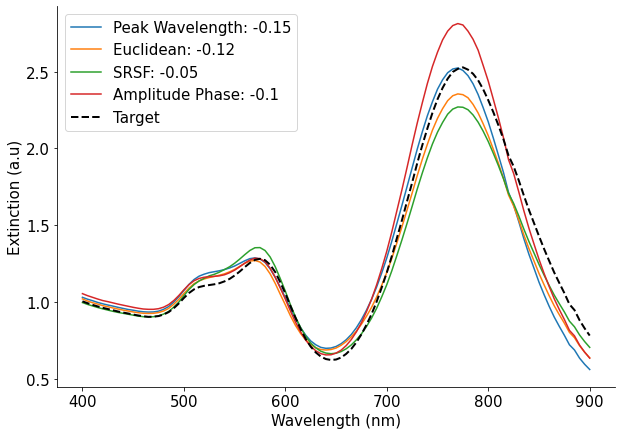

In [112]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(wavelength, peakwv_ROD[-1,3:], label = 'Peak Wavelength: ' + str(round(peakwv_ROD[-1,0], 2)))
plt.plot(wavelength, euclidean_ROD[-1,3:], label = 'Euclidean: ' + str(round(euclidean_ROD[-1,0], 2)))
plt.plot(wavelength, SRVF_ROD[-1,3:], label = 'SRSF: ' + str(round(SRVF_ROD[-1,0],2)))
plt.plot(wavelength, AP_ROD[-1,3:], label = 'Amplitude Phase: ' + str(round(AP_ROD[-1,0], 2)))
plt.plot(wavelength, rod_target,linewidth = 2.0, ls='--', color = 'k', label = 'Target')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Extinction (a.u)')
plt.savefig('../figures/same_metric_distance/SRSF_RODS.png')

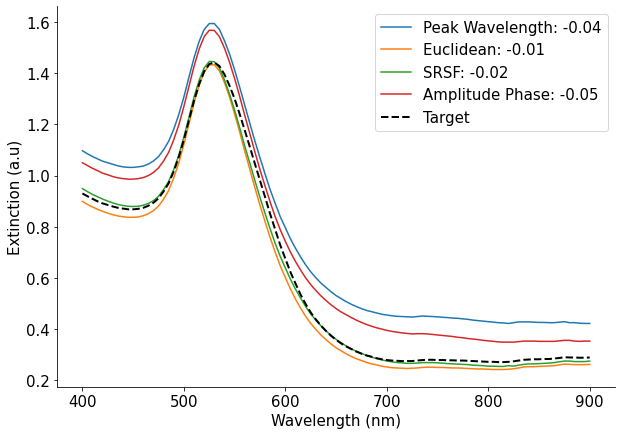

In [113]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(wavelength, peakwv_SPHERE[-1,3:], label = 'Peak Wavelength: ' + str(round(peakwv_SPHERE[-1,0], 2)))
plt.plot(wavelength, euclidean_SPHERE[-1,3:], label = 'Euclidean: ' + str(round(euclidean_SPHERE[-1,0], 2)))
plt.plot(wavelength, SRVF_SPHERE[-1,3:], label = 'SRSF: ' + str(round(SRVF_SPHERE[-1,0],2)))
plt.plot(wavelength, AP_SPHERE[-1,3:], label = 'Amplitude Phase: ' + str(round(AP_SPHERE[-1,0], 2)))
plt.plot(wavelength, sphere_target,linewidth = 2.0, ls='--', color = 'k', label = 'Target')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Extinction (a.u)')
plt.savefig('../figures/same_metric_distance/SRSF_SPHERES.png')

In [76]:
metric_name = AP
peakwv_SPHERE = calculate_distance(metric_name, peakwv_SPHERE_x, peakwv_SPHERE_y, sphere_target)
peakwv_ROD = calculate_distance(metric_name, peakwv_ROD_x, peakwv_ROD_y, rod_target)
euclidean_ROD = calculate_distance(metric_name, euclidean_ROD_x, euclidean_ROD_y, rod_target)
euclidean_SPHERE = calculate_distance(metric_name, euclidean_SPHERE_x, euclidean_SPHERE_y, sphere_target)
SRVF_ROD = calculate_distance(metric_name, SRVF_ROD_x, SRVF_ROD_y, rod_target)
SRVF_SPHERE = calculate_distance(metric_name, SRVF_SPHERE_x, SRVF_SPHERE_y, sphere_target)
AP_ROD = calculate_distance(metric_name, AP_ROD_x, AP_ROD_y, rod_target)
AP_SPHERE = calculate_distance(metric_name, AP_SPHERE_x, AP_SPHERE_y, sphere_target)

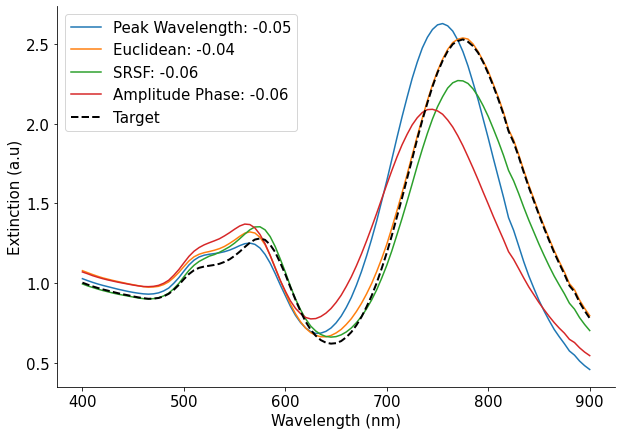

In [92]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(wavelength, peakwv_ROD[-1,3:], label = 'Peak Wavelength: ' + str(round(peakwv_ROD[-1,0], 2)))
plt.plot(wavelength, euclidean_ROD[-1,3:], label = 'Euclidean: ' + str(round(euclidean_ROD[-1,0], 2)))
plt.plot(wavelength, SRVF_ROD[-1,3:], label = 'SRSF: ' + str(round(SRVF_ROD[-1,0],2)))
plt.plot(wavelength, AP_ROD[-1,3:], label = 'Amplitude Phase: ' + str(round(AP_ROD[-1,0], 2)))
plt.plot(wavelength, rod_target,linewidth = 2.0, ls='--', color = 'k', label = 'Target')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Extinction (a.u)')
plt.savefig('../figures/same_metric_distance/AP_RODS.png')

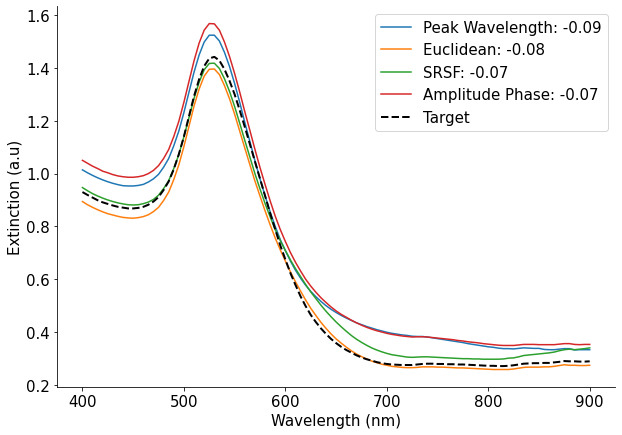

In [89]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(wavelength, peakwv_SPHERE[-1,3:], label = 'Peak Wavelength: ' + str(round(peakwv_SPHERE[-1,0], 2)))
plt.plot(wavelength, euclidean_SPHERE[-1,3:], label = 'Euclidean: ' + str(round(euclidean_SPHERE[-1,0], 2)))
plt.plot(wavelength, SRVF_SPHERE[-1,3:], label = 'SRSF: ' + str(round(SRVF_SPHERE[-1,0],2)))
plt.plot(wavelength, AP_SPHERE[-1,3:], label = 'Amplitude Phase: ' + str(round(AP_SPHERE[-1,0], 2)))
plt.plot(wavelength, sphere_target,linewidth = 2.0, ls='--', color = 'k', label = 'Target')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Extinction (a.u)')
plt.savefig('../figures/same_metric_distance/AP_SPHERES.png')

In [150]:
plt.rcParams.update({
                     "axes.spines.right" : False,
                     "axes.spines.top" : False,
                     "font.size": 8,
                     "savefig.dpi": 400,
                     "savefig.bbox": 'tight',
                     'text.latex.preamble': r'\usepackage{amsfonts}'
                    }
                   )

Text(-4, 0.03, 'Amplitude Phase')

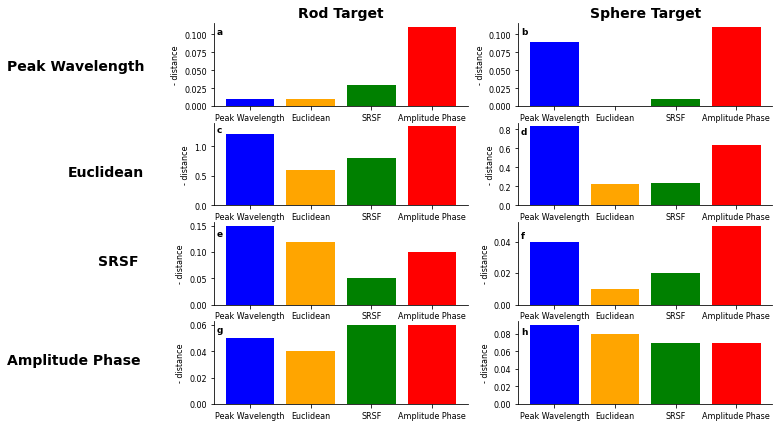

In [208]:
fig, ax = plt.subplots(figsize=(10,7), ncols = 2, nrows = 4)
ax[0,0].bar(['Peak Wavelength'], [0.01], color = 'blue')
ax[0,0].bar(['Euclidean'], [0.01], color = 'orange')
ax[0,0].bar(['SRSF'], [0.03], color = 'green')
ax[0,0].bar(['Amplitude Phase'], [0.11], color = 'red')
ax[0,0].set_ylabel('- distance')
ax[0,1].bar(['Peak Wavelength'], [0.09], color = 'blue')
ax[0,1].bar(['Euclidean'], [0.0], color = 'orange')
ax[0,1].bar(['SRSF'], [0.01], color = 'green')
ax[0,1].bar(['Amplitude Phase'], [0.11], color = 'red')
ax[0,1].set_ylabel('- distance')
ax[1,0].bar(['Peak Wavelength'], [1.21], color = 'blue')
ax[1,0].bar(['Euclidean'], [0.6], color = 'orange')
ax[1,0].bar(['SRSF'], [0.81], color = 'green')
ax[1,0].bar(['Amplitude Phase'], [1.34], color = 'red')
ax[1,0].set_ylabel('- distance')
ax[1,1].bar(['Peak Wavelength'], [0.83], color = 'blue')
ax[1,1].bar(['Euclidean'], [0.22], color = 'orange')
ax[1,1].bar(['SRSF'], [0.23], color = 'green')
ax[1,1].bar(['Amplitude Phase'], [0.64], color = 'red')
ax[1,1].set_ylabel('- distance')
ax[2,0].bar(['Peak Wavelength'], [0.15], color = 'blue')
ax[2,0].bar(['Euclidean'], [0.12], color = 'orange')
ax[2,0].bar(['SRSF'], [0.05], color = 'green')
ax[2,0].bar(['Amplitude Phase'], [0.10], color = 'red')
ax[2,0].set_ylabel('- distance')
ax[2,1].bar(['Peak Wavelength'], [0.04], color = 'blue')
ax[2,1].bar(['Euclidean'], [0.01], color = 'orange')
ax[2,1].bar(['SRSF'], [0.02], color = 'green')
ax[2,1].bar(['Amplitude Phase'], [0.05], color = 'red')
ax[2,1].set_ylabel('- distance')
ax[3,0].bar(['Peak Wavelength'], [0.05], color = 'blue')
ax[3,0].bar(['Euclidean'], [0.04], color = 'orange')
ax[3,0].bar(['SRSF'], [0.06], color = 'green')
ax[3,0].bar(['Amplitude Phase'], [0.06], color = 'red')
ax[3,0].set_ylabel('- distance')
ax[3,1].bar(['Peak Wavelength'], [0.09], color = 'blue')
ax[3,1].bar(['Euclidean'], [0.08], color = 'orange')
ax[3,1].bar(['SRSF'], [0.07], color = 'green')
ax[3,1].bar(['Amplitude Phase'], [0.07], color = 'red')
ax[3,1].set_ylabel('- distance')
ax[0,0].text(-0.55,0.1, 'a', fontsize = 9, fontweight='bold')
ax[0,1].text(-0.55,0.1, 'b', fontsize = 9, fontweight='bold')
ax[1,0].text(-0.55,1.25, 'c', fontsize = 9, fontweight='bold')
ax[1,1].text(-0.55,0.75, 'd', fontsize = 9, fontweight='bold')
ax[2,0].text(-0.55,0.13, 'e', fontsize = 9, fontweight='bold')
ax[2,1].text(-0.55,0.042, 'f', fontsize = 9, fontweight='bold')
ax[3,0].text(-0.55,0.055, 'g', fontsize = 9, fontweight='bold')
ax[3,1].text(-0.55,0.08, 'h', fontsize = 9, fontweight='bold')
ax[0,0].set_title('Rod Target', fontsize = 14, fontweight = 'bold')
ax[0,1].set_title('Sphere Target', fontsize = 14, fontweight = 'bold')
#ax[0,1].text(4,0.050, 'Peak Wavelength', fontsize = 14, fontweight='bold')
ax[0,0].text(-4,0.050, 'Peak Wavelength', fontsize = 14, fontweight='bold')
ax[1,0].text(-3,0.50, 'Euclidean', fontsize = 14, fontweight='bold')
ax[2,0].text(-2.5,0.075, 'SRSF', fontsize = 14, fontweight='bold')
ax[3,0].text(-4,0.03, 'Amplitude Phase', fontsize = 14, fontweight='bold')
#plt.savefig('../figures/same_metric_distance/all_bar_plots.png')